In [135]:
from collections import defaultdict

import gseapy as gp
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 200)

import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import leaves_list, linkage
from scipy.spatial.distance import pdist, squareform

from scripts import aesthetics
from scripts import manuscript_colors as mc

aesthetics.activate_paper_rcParams('illustrator')

In [136]:
import palettable

Bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

# GSEA Figures

I was trying to make figures in the general analysis notebook (`analyze_gsea_results`), but that notebook is huge and is asking very high level questions. I wanted to make a notebook where I could just make some figures.

# Read in data

## Category SVs

In [137]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/CWAS data for Jett/List of variants by category/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding


## Framework results

In [141]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/CWAS data for Jett/CWAS sum stats/*.txt"):
    if "12_26_23" not in file:
        continue

    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"
    af_category = "singleton" if "SINGLETON" in file else "rare"

    data = pd.read_csv(file, sep="\t")
    data[["disease", "sv_category", "af_category"]] = [
        disease,
        sv_category,
        af_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)

In [142]:
num_tests = {
    "neuroblastoma-coding": 279,
    "neuroblastoma-noncoding": 940,
    "ewing-coding": 267,
    "ewing-noncoding": 916,
    "osteosarcoma-coding": 270,
    "osteosarcoma-noncoding": 930
}

bonf_nlp_thresholds = {d: -np.log10(0.05 / n_test) for d, n_test in num_tests.items()}

framework_results["bonferroni_p"] = framework_results.apply(
    lambda row: row["p_value"] * num_tests[row["disease"] + "-" + row["sv_category"]],
    axis=1,
)

framework_results["bonferroni_significant"] = framework_results["bonferroni_p"] < 0.05

In [143]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):
    if "osteosarcoma" in file:
        continue

    disease = "neuroblastoma" if "neuroblastoma" in file else "ewing"
    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

## GSEA results

In [144]:
ref_counts = pd.read_csv("data/cwas-results/reference-counts.csv")

In [145]:
gse_results = pd.read_csv("data/cwas-results/cwas-gene-set-enrichment-results.csv")
binom_results = pd.read_csv("data/cwas-results/cwas-category-gs-binomial-results.csv")

# subset data
gse_results = gse_results[
    gse_results["category"].isin(framework_results["category_name"].tolist())
]
binom_results = binom_results[
    binom_results["category"].isin(framework_results["category_name"].tolist())
]

# reformat and merge
overlap_cols = ["disease", "category", "sv_category", "db", "gs"]
gse_results.columns = [
    c + "_fisher" if c not in overlap_cols else c for c in gse_results.columns
]
binom_results.columns = [
    c + "_binom" if c not in overlap_cols else c for c in binom_results.columns
]

combined_gse_results = gse_results.merge(binom_results, on=overlap_cols).copy()

Add some labels:

In [146]:
category_to_expression = {
    c: c.split(".")[4] if len(c.split(".")) == 6 else c.split(".")[6]
    for c in framework_results["category_name"].tolist()
}
category_to_functional = {
    c: c.split(".")[3] if len(c.split(".")) == 8 else np.nan
    for c in framework_results["category_name"].tolist()
}

combined_gse_results["expression"] = [
    category_to_expression[c] for c in combined_gse_results["category"]
]
combined_gse_results["functional_category"] = [
    category_to_functional[c] for c in combined_gse_results["category"]
]

### Do some prefiltering

In [147]:
combined_gse_results = combined_gse_results[
    combined_gse_results["analysis_fisher"] == "full"
]

# we remove all non GO terms here
combined_gse_results = combined_gse_results[combined_gse_results['db'] == "GO_Biological_Process_Full"]

## Gene sets

In [148]:
# obtained by searching "adrenal gland" on go
adrenal_gs = pd.read_csv('data/adrenal-gene-sets.txt', sep = '\t', header = None, names = ['go', 'gs'])
adrenal_gs = list(adrenal_gs['gs'] + ' (' + adrenal_gs['go'] + ')')

In [149]:
gene_sets = {}
dbs = set()
with open("ref/gene-sets.txt") as gs_in:
    for line in gs_in:
        comp = line.strip().split("\t")
        db = comp[0]
        dbs.add(db)
        gs = comp[1]
        genes = comp[2:]
        
        if db in ['Reactome_2022', 'GO_Biological_Process_Specific']:
            continue
            
        if gs in adrenal_gs:
            gene_sets[f'adrenal | {gs}'] = genes
        
        elif len(genes) >= 30 and len(genes) <= 1000:
            gene_sets[db + " | " + gs] = genes

In [150]:
with open('data/gtex-tissue-specific-gene-sets.txt') as infile:
    for line in infile.readlines():
        line = line.strip()
        tissue = line.split(' | ')[0].lower()
        genes = line.split(' | ')[1].split(',')
        
        gene_sets[f'gtex | {tissue}'] = genes

In [151]:
print(len(gene_sets))

3137


In [169]:
len([g for g in gene_sets if 'GO_Biological_Process_Full' in g])

2722

We are only going to examine GO terms here:

In [170]:
num_effective_gene_sets = 2722
p_bonf_cutoff = 0.05 / 2722

Here's some code just to export for Riaz's review

In [171]:
export = combined_gse_results[['disease', 'category', 'gs', 'sv_category',
                      'ref_freq_cases_fisher', 'cat_freq_cases_fisher', 'p_cases_fisher', 'odds_ratio_cases_fisher', 'num_unique_genes_in_overlap_cases_fisher',
                      'ref_freq_controls_fisher', 'cat_freq_controls_fisher', 'p_controls_fisher', 'odds_ratio_controls_fisher', 'num_unique_genes_in_overlap_controls_fisher']]

export.columns = ['disease', 'category', 'gs', 'sv_category',
                  'outside_cat_freq_cases_fisher', 'inside_cat_freq_cases_fisher', 'p_cases_fisher', 'odds_ratio_cases_fisher', 'num_unique_genes_in_overlap_cases_fisher',
                  'outside_cat_freq_controls_fisher', 'inside_cat_freq_controls_fisher', 'p_controls_fisher', 'odds_ratio_controls_fisher', 'num_unique_genes_in_overlap_controls_fisher']

rename = {'category_name': 'category', 
          'negative_log10_p_value': 'category_negative_log10_p_value', 
          'bonferroni_significant': 'category_bonferroni_significant'}

merged = framework_results[['disease', 'category_name', 'sv_category', 'negative_log10_p_value', 'bonferroni_significant']].rename(columns = rename)
export = merged.merge(export, how = 'right')

for col in ['p_cases_fisher', 'p_controls_fisher']:
    index = list(export.columns).index(col)
    values = export[col] < 0.05 / 2259
    export.insert(index + 1, col + '_bonferroni', values)
    
export.to_csv('gsea-results-export-for-riaz.csv', index=False)

In [172]:
combined_gse_results = merged.merge(combined_gse_results, how = 'right')

# Plot the category results

This is just replicating what Riaz did, for fun

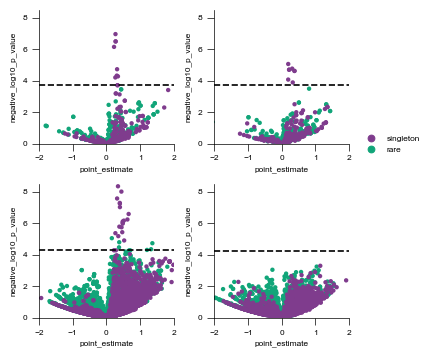

In [173]:
fig, axes = plt.subplots(
    2, 2, figsize=(4, 4), gridspec_kw={"hspace": 0.3, "wspace": 0.3}
)

for i, disease in enumerate(["neuroblastoma", "ewing"]):
    for j, sv_category in enumerate(["coding", "noncoding"]):
        ax = axes[j, i]
        data = framework_results.query(
            f'disease == "{disease}" & sv_category == "{sv_category}"'
        ).sort_values(by="af_category")
        sns.scatterplot(
            x="point_estimate",
            y="negative_log10_p_value",
            data=data,
            ax=ax,
            hue="af_category",
            ec=None,
            hue_order=["singleton", "rare"],
            s=10,
        )
        sns.despine(ax=ax)

        ax.set_ylim([-0.01, 8.5])
        ax.set_xlim([-2, 2])

        # look up threshold
        thresh = bonf_nlp_thresholds[f"{disease}-{sv_category}"]
        ax.axhline(y=thresh, color="black", linestyle="dashed")
        ax.legend().remove()

        if i == 1 and j == 0:
            ax.legend(bbox_to_anchor=(1.05, 0))

We won't pretty them any more than that. Useful to reproduce.

# Plot gene set results for a subset of categories

I like the idea of showing the full spectrum of analyzed gene sets for a category (or a subset of categories, perhaps). Let's first show ALL categories for the diseases.

We're focusing on baseline enrichment here.

Text(0.5, 0, 'odds-ratio')

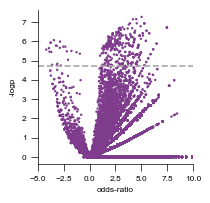

In [174]:
fig, ax = plt.subplots(1, figsize=(2, 2))

data = combined_gse_results.query(
    'disease == "neuroblastoma" & sv_category == "coding"'
).copy()
data["x_baseline"] = np.log2(data["odds_ratio_cases_fisher"])
data["y_baseline"] = -np.log10(data["p_cases_fisher"])

sns.scatterplot(x="x_baseline", y="y_baseline", data=data, s=3, ec=None)
sns.despine(ax=ax)
ax.set_xlim([-5, 10])
ax.axhline(
    y=-np.log10(0.05 / num_effective_gene_sets), linestyle="dashed", color="darkgrey"
)
ax.set_ylabel("-logp")
ax.set_xlabel("odds-ratio")

So pretty hard to interpret. Let's subset down to some example categories

In [175]:
bonferroni_cats = framework_results.query(
    'sv_category == "coding" & bonferroni_significant == True'
)
bonferroni_cats["category_name"].value_counts()

DEL.SINGLETON.ANY.ANY.ANY.protein_coding                                                                     2
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding                             2
ANY.SINGLETON.ANY.ANY.ANY.protein_coding                                                                     2
DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding                             2
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding                   1
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding      1
ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding                                                           1
ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding                                              1
ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding    1
A

So a few categories are present in both. I think it makes the most sense to show the top level category, since that's very interesting in terms of baseline findings.

In [176]:
labeled_gs = ['central nervous system development (GO:0007417)', 'positive regulation of synaptic transmission (GO:0050806)',
      'regulation of protein depolymerization (GO:1901879)', 'regulation of actin filament-based process (GO:0032970)']

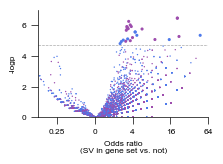

In [177]:
test_cat = "ANY.SINGLETON.ANY.ANY.ANY.protein_coding"

palette = {'neuroblastoma': mc.palette['neuroblastoma']["main"],
           'ewing': mc.palette['ewing']["main"]}

fig, ax = plt.subplots(1, figsize=(2.2, 1.4))

coding_results = combined_gse_results.query('sv_category == "coding"').copy()
coding_results["x_baseline"] = np.log2(coding_results["odds_ratio_cases_fisher"])
coding_results["y_baseline"] = -np.log10(coding_results["p_cases_fisher"])

data = coding_results.query(f'category == "{test_cat}"').copy()

nlp_bonf = -np.log10(p_bonf_cutoff)
data['size'] = np.where(data['y_baseline'] > nlp_bonf, 5, 1)
data['c'] = data['disease'].replace(palette)

# plot the significant ones first
sig = data.query(f'y_baseline > {nlp_bonf}')
points = ax.scatter(x = sig['x_baseline'], y = sig['y_baseline'], s = sig['size'], ec = None, c = sig['c'])

# labeled_sig = sig[sig['gs'].isin(labeled_gs)]
# points = ax.scatter(x = labeled_sig['x_baseline'], y = labeled_sig['y_baseline'], s = 10, ec = None, c = 'black')

nonsig = data.query(f'y_baseline < {nlp_bonf}').sample(frac = 1)
for chunk in np.array_split(nonsig, 200):
    zorder = np.random.uniform()
    points = ax.scatter(x = chunk['x_baseline'], y = chunk['y_baseline'], s = chunk['size'], ec = None, c = chunk['c'])

sns.despine(ax=ax)
ax.set_xlim([-3, 6])
ax.set_ylim([0, 7])
ax.axhline(
    y=nlp_bonf,
    linestyle="dashed",
    color="darkgrey",
    zorder=-1,
    linewidth = 0.5
)
ax.set_ylabel("-logp")
ax.set_xlabel("Odds ratio\n(SV in gene set vs. not)", fontsize = 6)

ax.set_xticks([-2, 0, 2, 4, 6])
ax.set_xticklabels([0.25, 0, 4, 16, 64])

# ax.legend(bbox_to_anchor = (1, 0.5))

fig.savefig('images/test-gene-sets-any.pdf')

In [92]:
0.000009

9e-06

Interesting... these do actually differ a little bit. I kind of like that third figure (reduces redundancy between A and B). Can we depict this alone?

What about if we look at the next level down > expressed in adrenal vs. muscle? Do things change?

# Try to visualize some case-control odds ratios

So we've shown that the odd's ratios are up in cases - we have the comparison in controls.

There are a few category-gene set pairs that I'd like to highlight. We also have some that Riaz highlighted for us.

In [40]:
riaz_annotations = pd.read_csv('data/gsea_results_export_for_riaz_bonferroni_significant_annotated_3_12_24.tsv', sep = '\t')

In [60]:
category_geneset_pairs = [['neuroblastoma', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding', 'central nervous system development (GO:0007417)'],
                          ['neuroblastoma', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['neuroblastoma', 'DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding', 'positive regulation of synaptic transmission (GO:0050806)'],
                          ['ewing', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'regulation of protein depolymerization (GO:1901879)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'regulation of protein depolymerization (GO:1901879)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 'regulation of protein depolymerization (GO:1901879)'],
                          ['ewing', 'ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 'regulation of actin filament-based process (GO:0032970)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding', 'regulation of actin filament-based process (GO:0032970)'],
                          ['ewing', 'DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 'regulation of actin filament-based process (GO:0032970)'],
                          # ['neuroblastoma', 'ANY.RARE.ANY.ANY.ANY.protein_coding', 'heterochromatin organization (GO:0070828)'],
                          # ['neuroblastoma', 'DEL.RARE.ANY.ANY.ANY.protein_coding', 'heterochromatin organization (GO:0070828)'],
                          # ['neuroblastoma', 'DEL.RARE.ANY.lof_constrained.ANY.protein_coding', 'heterochromatin organization (GO:0070828)']
                         ]

category_geneset_pairs = np.array(category_geneset_pairs)

We also add a calculation for the odds ratio confidence intervals.

In [61]:
import statsmodels.api as sm

In [130]:
def calculate_or_ci(row):
    
    results = []
    for cohort in ['cases', 'controls']:
        top_row = row[f'cat_freq_{cohort}_fisher'].split('/')
        bottom_row = row[f'ref_freq_{cohort}_fisher'].split('/')
        
        table = np.array([top_row, bottom_row]).astype(int)
        
        table = sm.stats.Table2x2(table)
        
        odds = table.log_oddsratio
        ci = table.log_oddsratio_confint()
        
        results += [odds] + list(ci)
        
    return results

In [131]:
plot_results = []
odds_ratio_intervals = []
for dz, cat, gs in category_geneset_pairs:
    res = combined_gse_results[lambda row: (row['disease'] == dz) & 
                               (row['category'] == cat) & 
                               (row['gs'] == gs) & 
                               (row['sv_category'] == "coding")]

    assert len(res) == 1
    
    odds_ratios = calculate_or_ci(res.iloc[0])
    odds_ratio_intervals.append(odds_ratios)
    
    plot_results.append(res)
    
plot_results = pd.concat(plot_results).reset_index()

# convert from ln to log2
odds_ratio_intervals = np.array(odds_ratio_intervals) / np.log(2)

plot_results[['cases_logor', 'cases_logor_upper', 'cases_logor_lower', 'controls_logor', 
              'controls_logor_upper', 'controls_logor_lower']] = odds_ratio_intervals

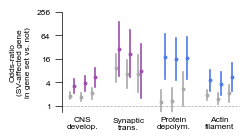

In [134]:
fig, ax = plt.subplots(1, figsize = (2.3, 1.3)) 
                         # gridspec_kw = {'hspace': 0.1, 'height_ratios': [1, 0.2]}, sharex = True)

x = 0
xticks = []
for index, row in plot_results.iterrows():
    dz = row['disease']
    
    for cohort in ['controls', 'cases']:
        
        color = palette[dz] if cohort == "cases" else "darkgrey"
        
        y_val = row[f'{cohort}_logor']
        y_upper = row[f'{cohort}_logor_upper']
        y_lower = row[f'{cohort}_logor_lower']
        ax.scatter([x], [y_val], s = 4, color = color)
        ax.plot([x, x], [y_upper, y_lower], color = color)
    
        if cohort == 'controls':
            xticks.append(x + 0.4)

        x += 0.8

    x += 1
    
    if (index + 1) % 3 == 0:
        x += 3
        
ax.set_yticks([-2, 0, 2, 4, 6, 8])
ax.set_yticklabels([0.25, 1, 4, 16, 64, 256])
ax.set_ylim([-0.5, 8])
ax.axhline(y = 0, color = 'darkgrey', linestyle = 'dashed', zorder = -1, linewidth = 0.5)
aesthetics.strip_axis(ax, x = 'label', y = 'ignore')
ax.set_ylabel('Odds-ratio\n(SV-affected gene\nin gene set vs. not)')
ax.set_xticks(xticks[1::3])
ax.set_xticklabels(['CNS\ndevelop.', 'Synaptic\ntrans.', 'Protein\ndepolym.', 'Actin\nfilament'], fontsize = 6)

# add the "legend" component
# ax = axes[1]
# ax.set_ylim([-0.5, 4])

# for i, x in enumerate(xticks):
#     ax.scatter([x], [3], s = 3, color = 'darkgrey')
    
# aesthetics.strip_axis(ax = ax, x = 'label')
    
# ax.scatter(xticks, [0.5] * len(xticks))
# ax.set_xticks(xticks)
# ax.set_xticklabels(['CNS\ndevelop.', 'synaptic\ntrans.', 'protein\ndepolym.', 'actin\ncytoskeleton'], fontsize = 6)
# ax.text(x = 0.5, y = 1.1, s = 'singletons > deletions > expressed in tissue', transform = ax.transAxes, ha = 'center', va = 'bottom')

fig.savefig('images/gene-set-odds-ratios.pdf')

In [67]:
!open images

In [46]:
paths = {'lof_constrained': 'data/CWAS data for Jett/lof_constrained_genes_7_31_23 (1).txt',
         'missense_constrained': 'data/CWAS data for Jett/missense_constrained_genes_7_31_23.txt',
         'unconstrained': 'data/CWAS data for Jett/unconstrained_genes_7_31_23.txt',
         'expressed_in_adrenal_gland': 'data/CWAS data for Jett/top_expressed_in_adrenal_gland_7_31_23 (1).txt',
         'protein_coding': 'data/CWAS data for Jett/gencode_hg38_protein_coding_genes_for_annotation_7_31_23 (1).txt',
         'cosmic_and_germline_CPGs': 'data/CWAS data for Jett/cosmic_cancer_genes_tier_one_and_germline_CPGs_10_23_23 (1).txt',
         'expressed_in_muscle_skeletal': 'data/CWAS data for Jett/top_expressed_in_muscle_skeletal_7_31_23.txt'}

gene_restrictions = {}
for label, path in paths.items():
    data = pd.read_csv(path)
    data = data[~data['value'].str.startswith('ENSG00')]
    data = data['value'].tolist()

    gene_restrictions[label] = data

In [47]:
gene_sets_ref = ['GO_Biological_Process_Full | central nervous system development (GO:0007417)', 
                 'GO_Biological_Process_Full | positive regulation of synaptic transmission (GO:0050806)']

gene_sets_test = ['expressed_in_adrenal_gland',
                  'gtex | adrenal-gland-rank-100', 'gtex | adrenal-gland-exp-100',
                  'gtex | adrenal-gland-rank-200', 'gtex | adrenal-gland-exp-200',
                  'gtex | adrenal-gland-rank-500', 'gtex | adrenal-gland-exp-500']

for gs in gene_sets_test:
    print(gs)
    if gs == 'expressed_in_adrenal_gland':
        test_genes = gene_restrictions['expressed_in_adrenal_gland']
    else:
        test_genes = gene_sets[gs]
        
    for gs_test in gene_sets_ref:
        test_genes_2 = gene_sets[gs_test]
        
        overlap_gs = len(set(test_genes_2) & set(test_genes)) / len(test_genes)
        overlap_ref = len(set(test_genes_2) & set(gene_ref)) / len(gene_ref)
        # compare
        print(overlap_gs, overlap_ref)
        
    print('----')


test = gene_sets['GO_Biological_Process_Full | central nervous system development (GO:0007417)']
test2 = gene_sets['GO_Biological_Process_Full | positive regulation of synaptic transmission (GO:0050806)']
adrenal = gene_restrictions['expressed_in_adrenal_gland']

print(len(test), len(adrenal), len(set(test) & set(adrenal)))
print(len(test), len(gene_ref), len(set(test) & set(gene_ref)))

expressed_in_adrenal_gland


NameError: name 'gene_ref' is not defined

In [429]:
505/9505

0.05312993161493951

In [419]:
gene_ref_path = "data/CWAS data for Jett/gencode_hg38_protein_coding_genes_for_annotation_7_31_23 (1).txt"

gene_ref = pd.read_csv(gene_ref_path)
gene_ref = gene_ref[~gene_ref["value"].str.startswith("ENSG00")]
gene_ref = sorted(set(gene_ref["value"].tolist()))
len(gene_ref)

19201

In [318]:
table = np.asarray([[31, 461], [81, 3485]]) + 1

t22 = sm_stats.contingency_tables.Table2x2(table)

print(t22.summary())

               Estimate   SE   LCB   UCB  p-value
-------------------------------------------------
Odds ratio        2.945       1.935 4.481   0.000
Log odds ratio    1.080 0.214 0.660 1.500   0.000
Risk ratio        2.819       1.894 4.195   0.000
Log risk ratio    1.036 0.203 0.639 1.434   0.000
-------------------------------------------------


In [ ]:
combined_gse_results[(combined_gse_results['disease'] == "neuroblastoma") &
                     (combined_gse_results['gs'])]

In [254]:
framework_results.query('category_name == "DEL.RARE.ANY.lof_constrained.ANY.protein_coding"')

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,disease,sv_category,af_category,bonferroni_p,bonferroni_significant
250,0.290127,0.136718,2.122077,0.033831,61,2,694,751,267,5,4199,4449,317,DEL.RARE.ANY.lof_constrained.ANY.protein_coding,DEL,RARE,0.081225,0.060013,0.063077,1.470681,ewing,coding,rare,9.032957,False
272,0.439906,0.123258,3.568985,0.000358,67,3,596,646,282,5,4435,4699,317,DEL.RARE.ANY.lof_constrained.ANY.protein_coding,DEL,RARE,0.103715,0.060013,0.065295,3.445671,neuroblastoma,coding,rare,0.099985,False


In [233]:
test = combined_gse_results.query('disease == "neuroblastoma" & gs == "heterochromatin organization (GO:0070828)" & sv_category == "coding" & category_negative_log10_p_value > 1.3').set_index('category')
test.loc[category_geneset_pairs[:, 0]]

,disease,sv_category,category_negative_log10_p_value,category_bonferroni_significant,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expression,functional_category
category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ANY.SINGLETON.ANY.ANY.ANY.protein_coding,neuroblastoma,coding,6.144705,True,full,GO_Biological_Process_Full,central nervous system development (GO:0007417),80/3512,32/434,27,3.470545,5.754010e-07,0.000512,0.001301,568/23877,111/2560,78,1.872759,0.000003,0.000049,0.005922,21/398,18/224,18,1.577075,0.173373,1.0,391.995356,0.051697,0.073733,0.049713,0.794063,112.401325,27,0.051697,0.043359,0.060623,0.281323,137.068652,78,0.051697,0.080357,0.067423,1.0,152.442977,18,ANY,NaN
DEL.SINGLETON.ANY.ANY.ANY.protein_coding,neuroblastoma,coding,6.492314,True,full,GO_Biological_Process_Full,central nervous system development (GO:0007417),83/3614,29/332,24,4.149436,1.050550e-06,0.000357,0.002375,601/24559,78/1878,57,1.745764,0.000028,0.000473,0.062576,24/453,15/169,15,1.775484,0.135016,1.0,305.271933,0.051697,0.087349,0.006014,0.377339,13.598406,24,0.051697,0.041534,0.047479,0.290337,107.350866,57,0.051697,0.088757,0.036420,1.0,82.345841,15,ANY,NaN
DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,neuroblastoma,coding,3.184126,False,full,GO_Biological_Process_Full,central nervous system development (GO:0007417),94/3809,18/137,14,6.193333,1.027434e-06,0.000737,0.002323,639/25673,40/764,28,2.212144,0.000022,0.000424,0.050826,30/541,9/81,9,2.262483,0.079716,1.0,180.238379,0.053130,0.131387,0.000366,0.229773,0.828048,14,0.053130,0.052356,1.000000,1.000000,2261.000000,28,0.053130,0.111111,0.039954,1.0,90.335073,9,expressed_in_adrenal_gland,NaN


In [68]:
riaz_annotations = pd.read_csv('data/gsea_results_export_for_riaz_bonferroni_significant_annotated_3_12_24.tsv', sep = '\t')

In [86]:
test = riaz_annotations[riaz_annotations['seems_biologically_relevant'] == True][['disease', 'category', 'gs', 'odds_ratio_cases_fisher', 'p_cases_fisher', 'p_cases_fisher_bonferroni']]
test['-nlp'] = -np.log10(test['p_cases_fisher'])
test[test['gs'].str.contains('protein depoly')]

,disease,category,gs,odds_ratio_cases_fisher,p_cases_fisher,p_cases_fisher_bonferroni,-nlp
122,ewing,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,regulation of protein depolymerization (GO:1901879),15.314371,0.000009,True,5.059982
133,ewing,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,regulation of protein depolymerization (GO:1901879),14.910818,0.000019,True,4.709965


# Try to make a heat map

I've futzed around with the above to recognize that it isn't particularly helpful. It's just so amorphous and difficult to label.

A heatmap offers us the ability to show a subset of categories and a subset of gene sets. I think this is pretty helpful. Let's start by just showing the bonferroni significant categories - and within those, only the gene sets that are significant in each.

In [20]:
sig_categories = framework_results.query(
    'bonferroni_significant & sv_category == "coding"'
)
sig_categories = list(
    sig_categories["disease"] + " | " + sig_categories["category_name"]
)

heatmap_data = coding_results.copy()
heatmap_data["disease_category"] = (
    heatmap_data["disease"] + " | " + heatmap_data["category"]
)
heatmap_data = heatmap_data[heatmap_data["disease_category"].isin(sig_categories)]

# gene_sets_to_show = list(heatmap_data[heatmap_data['y_baseline'] > 4]['gs'].unique())
gene_sets_to_show = heatmap_data[
    (heatmap_data["y_baseline"] > -np.log10(0.05 / num_effective_gene_sets))
    # (heatmap_data['x_baseline'] > 2)
]

# drop if < 2 OR for neuroblastoma, < 1 for EWS
gene_sets_to_show = gene_sets_to_show[~((gene_sets_to_show['disease'] == "neuroblastoma") & (gene_sets_to_show['x_baseline'] < 2))]
gene_sets_to_show = gene_sets_to_show[~((gene_sets_to_show['disease'] == "ewing") & (gene_sets_to_show['x_baseline'] < 1))]

gene_sets_to_show = gene_sets_to_show['gs'].value_counts()

# only show hits in at least 2 categories
gene_sets_to_show = list(gene_sets_to_show[gene_sets_to_show > 1].index)
gene_sets_to_show.append('muscle structure development (GO:0061061)')
gene_sets_to_show.append('skeletal muscle tissue development (GO:0007519)')

heatmap_values = heatmap_data[heatmap_data["gs"].isin(gene_sets_to_show)]

heatmap_p = heatmap_values.pivot(
    index="disease_category", columns="gs", values="y_baseline"
)

heatmap_values = heatmap_values.pivot(
    index="disease_category", columns="gs", values="x_baseline"
)

heatmap_values = heatmap_values.loc[sig_categories].T
heatmap_p = heatmap_p.loc[sig_categories].T

In [21]:
print(len(gene_sets_to_show))

21


## Order the categories and gene sets

These gene sets and categories are redundant with each other. We should clearly order them by overlap.

### Order categories

The categories should pretty clearly be ordered by hierarchy.

In [22]:
category_order = [
    "neuroblastoma | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding",
    "neuroblastoma | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding",
    "neuroblastoma | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding",
    "ewing | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
]

In [23]:
gs_list = []
genes_list = []

for gs, genes in gene_sets.items():
    gs = gs.split(" | ")[1]
    if gs not in gene_sets_to_show:
        continue
    gs_list += [gs] * len(genes)
    genes_list += genes

gs_gene_matrix = pd.DataFrame()
gs_gene_matrix["gs"] = gs_list
gs_gene_matrix["gene"] = genes_list
gs_gene_matrix["value"] = 1

gs_gene_matrix = (
    gs_gene_matrix.pivot(columns="gs", index="gene", values="value").fillna(0).T
)

data_values = gs_gene_matrix.values.astype(bool)

j_dist = pdist(data_values, metric="jaccard")
j_dist = 1 - squareform(j_dist)

Z = linkage(j_dist, method="average")
ordered_indices = leaves_list(Z)

ordered_gs = gs_gene_matrix.index[ordered_indices]
print(len(ordered_gs))

j_dist = j_dist[ordered_indices, :][:, ordered_indices]
j_dist = pd.DataFrame(j_dist, index=ordered_gs, columns=ordered_gs);

21


Text(76.55729166666666, 0.5, '')

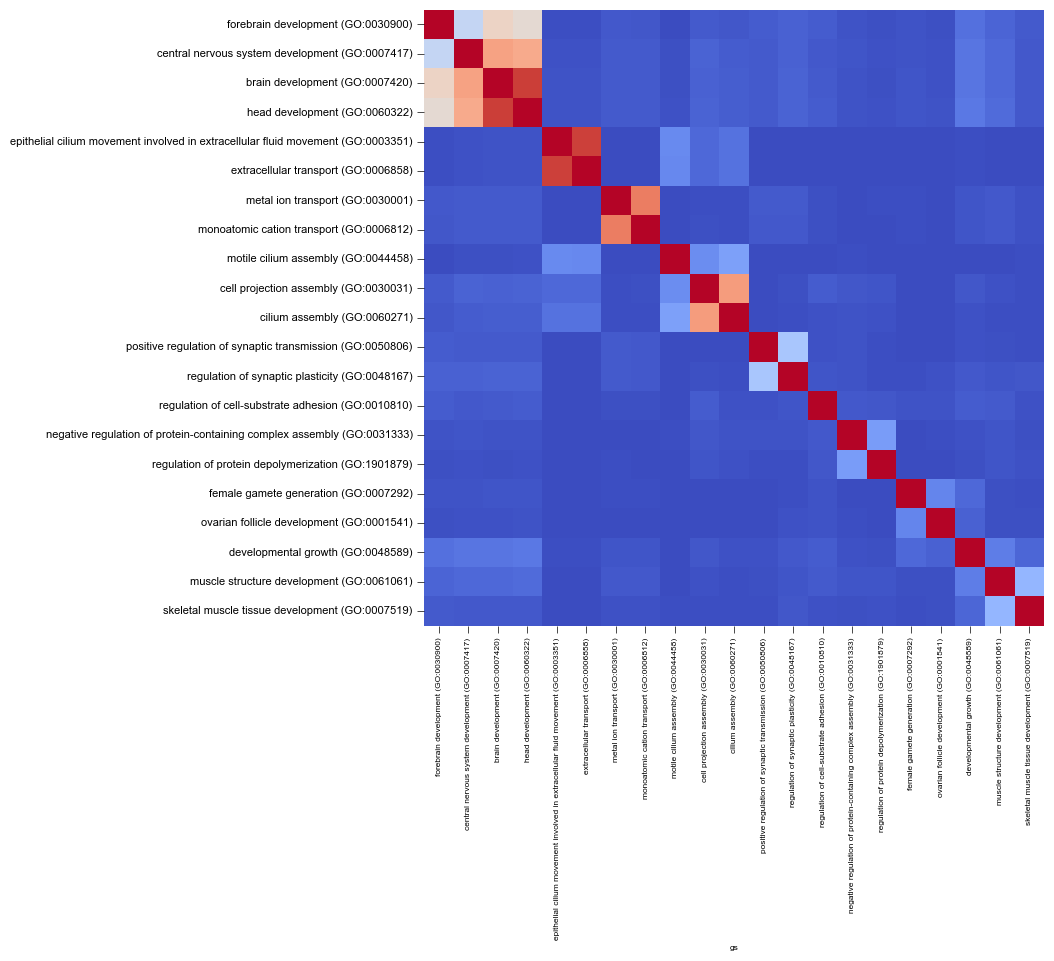

In [24]:
fig, ax = plt.subplots(1, figsize=(8, 8))
sns.heatmap(j_dist, annot=False, cmap="coolwarm", cbar=False)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 8)
ax.set_ylabel("")

In [25]:
# from scipy.spatial.distance import pdist, squareform
# from scipy.cluster.hierarchy import leaves_list, linkage

In [26]:
category_order = []
for disease in ["neuroblastoma", "ewing"]:
    order_data = category_svs.query(
        f'disease == "{disease}" & sv_category == "coding"'
    ).copy()
    order_data["disease_category"] = (
        order_data["disease"] + " | " + order_data["category"]
    )

    order_data = order_data[(order_data["disease_category"].isin(sig_categories))]
    order_data["value"] = 1

    # get the actual SVs present in cases
    svs_in_cases = list(
        set(
            ref_counts.query(
                f'sv_category == "coding" & disease == "{disease}" & cohort == "case" & dose > 0'
            )["name"]
        )
    )
    order_data = order_data[order_data["SV"].isin(svs_in_cases)]

    order_data_pivoted = order_data.pivot(
        columns="SV", index="disease_category", values="value"
    ).fillna(0)

    data_values = order_data_pivoted.values.astype(bool)

    j_dist = pdist(data_values, metric="jaccard")
    j_dist = 1 - squareform(j_dist)

    Z = linkage(j_dist, method="average")
    ordered_indices = leaves_list(Z)

    ordered_categories = order_data_pivoted.index[ordered_indices]
    print(ordered_categories)

    category_order += list(ordered_categories)

Index(['neuroblastoma | ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding',
       'neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding',
       'neuroblastoma | ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding',
       'neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding',
       'neuroblastoma | ANY.SINGLETON.ANY.ANY.ANY.protein_coding',
       'neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding',
       'neuroblastoma | DEL.SINGLETON.ANY.ANY.ANY.protein_coding',
       'neuroblastoma | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding'],
      dtype='object', name='disease_category')
Index(['ewing | ANY.SINGLETON.ANY.ANY.ANY.protein_coding',
       'ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding',
       'ewing | DEL.SINGLETON.AN

We drop some gene sets here:

In [27]:
dropped_gs = [
    "female pregnancy (GO:0007565)",
    "epithelial cilium movement involved in extracellular fluid movement (GO:0003351)",
    "extracellular transport (GO:0006858)",
    "motile cilium assembly (GO:0044458)",
    "cell projection assembly (GO:0030031)",
    "cilium assembly (GO:0060271)",
    "negative regulation of protein-containing complex assembly (GO:0031333)",
    "female gamete generation (GO:0007292)",
    "ovarian follicle development (GO:0001541)",
    "regulation of cell-substrate adhesion (GO:0010810)",
    'regulation of protein depolymerization (GO:1901879)',
    'developmental growth (GO:0048589)'
]

In [67]:
category_order = [
    "neuroblastoma | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "neuroblastoma | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    # "neuroblastoma | ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding",
    "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding",
    "neuroblastoma | ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding",
    # "neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.unconstrained.ANY.protein_coding",
    "ewing | ANY.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.ANY.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding",
    "ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding",
    "ewing | ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding",
]

Drop some gene sets and some categories (I dislike the unconstrained categories)

In [68]:
# ordered_gs = [gs for gs in ordered_gs if gs not in dropped_gs]
category_order = [cat for cat in category_order if 'unconstrained' not in cat]

gs_names = ['forebrain', 'CNS', 'brain', 'head', 'synaptic transmission', 'synaptic plasticity', 'metal ions', 'monoatomic cations', 'structure', 'skeletal muscle']

ordered_gs = ['forebrain development (GO:0030900)',
 'central nervous system development (GO:0007417)',
 'brain development (GO:0007420)',
 'head development (GO:0060322)',
             'positive regulation of synaptic transmission (GO:0050806)',
 'regulation of synaptic plasticity (GO:0048167)',
             'metal ion transport (GO:0030001)',
 'monoatomic cation transport (GO:0006812)',
             'muscle structure development (GO:0061061)',
             'skeletal muscle tissue development (GO:0007519)']

gs_to_name = dict(zip(ordered_gs, gs_names))

In [69]:
traits = ['expressed_in_',
 'PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP',
 'DEL']
trait_names = ['Gene expressed in\ntissue of origin', 'LoF SV', 'Deletion']
trait_matrix = []
for t in traits:
    row = []
    for c in category_order:
        value = 1 if t in c else 0
        row.append(value)
        
    trait_matrix.append(row)
    
trait_matrix = pd.DataFrame(trait_matrix, columns = category_order, index = traits)

In [70]:
trait_matrix.head(2)

,neuroblastoma | ANY.SINGLETON.ANY.ANY.ANY.protein_coding,neuroblastoma | DEL.SINGLETON.ANY.ANY.ANY.protein_coding,neuroblastoma | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,neuroblastoma | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,neuroblastoma | ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,ewing | ANY.SINGLETON.ANY.ANY.ANY.protein_coding,ewing | DEL.SINGLETON.ANY.ANY.ANY.protein_coding,ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,ewing | DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,ewing | ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding
expressed_in_,0,0,0,0,1,1,0,0,0,0,1,1,1,1
PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP,0,0,1,1,1,0,0,0,1,1,1,0,1,0


Alright, let's make this sucker.

In [71]:
groupings = {'neurodevelopment': ['forebrain development (GO:0030900)',
                                  'central nervous system development (GO:0007417)',
                                  'brain development (GO:0007420)',
                                  'head development (GO:0060322)'],
             'synapse biology': ['positive regulation of synaptic transmission (GO:0050806)',
                                 'regulation of synaptic plasticity (GO:0048167)'],
             'muscle development': ['muscle structure development (GO:0061061)',
                                    'skeletal muscle tissue development (GO:0007519)'],
             'ion transport': ['metal ion transport (GO:0030001)',
                               'monoatomic cation transport (GO:0006812)'],}

In [72]:
from matplotlib import colors

In [73]:
palette = {'neuroblastoma': mc.palette['neuroblastoma']["main"],
           'ewing': mc.palette['ewing']["main"]}

cmaps = {dz: colors.LinearSegmentedColormap.from_list(dz, ['white', col], N = 256) for dz, col in palette.items()}

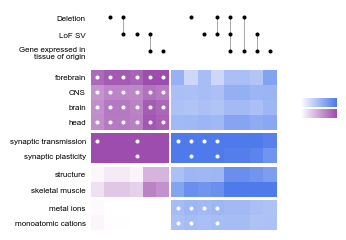

In [83]:
fig = plt.figure(figsize=(2.5, 3), tight_layout=False)
gs = fig.add_gridspec(6, 2, hspace = 0.1, wspace = 0.02, width_ratios = [6, 8], 
                       height_ratios = [1.7, 0.1, 2, 1, 1, 1])

# plot the category "labels"
cat_axes = []
for k, disease in enumerate(['neuroblastoma', 'ewing']):
    ax = fig.add_subplot(gs[0, k])
    cat_axes.append(ax)
    
    disease_cols = [c for c in trait_matrix.columns if disease in c]
    subtrait_matrix = trait_matrix.loc[:, disease_cols]

    for j in range(subtrait_matrix.shape[1]):

        connections = []

        for i in range(subtrait_matrix.shape[0]):
            val = subtrait_matrix.iloc[i, j]
            if val == 1:
                ax.scatter([j + 0.5], [i + 0.5], color = 'black', s = 5)
                connections.append(i + 0.5)

        # plot connecting lines
        if connections:
            ax.plot([j + 0.5] * len(connections), connections, color = 'darkgrey', zorder = 0, linewidth = 0.75)
            
    ax.set_ylim([0, 3])
    ax.set_xlim([0, subtrait_matrix.shape[1]])
    
    if k == 0:
        ax.set_yticks(np.arange(0, len(traits)) + 0.5)
        ax.set_yticklabels(trait_names, fontsize = 6)
        aesthetics.strip_axis(ax, y = 'label')
    else:
        aesthetics.strip_axis(ax)

# plot by each group - 3 x 2
for i, (g, g_gene_sets) in enumerate(groupings.items()):
    row = i + 2
    
    for j, disease in enumerate(['neuroblastoma', 'ewing']):
        sharex = cat_axes[j]
        ax = fig.add_subplot(gs[row, j], sharex = sharex)
        
        # get the data
        disease_cols = [c for c in category_order if disease in c]
        subheatmap = heatmap_values.loc[g_gene_sets, disease_cols]
        
        ax.set_xlim([0, len(disease_cols)])
        
        sns.heatmap(
            subheatmap,
            ax=ax,
            cmap=cmaps[disease],
            vmin=0,
            vmax=3,
            cbar = None
        )
        
        ax.set_yticks(np.arange(0, len(g_gene_sets)) + 0.5)
        
        for row_i, cat in enumerate(disease_cols):
            for row_j, sub_gs in enumerate(g_gene_sets):

                y_baseline = heatmap_p.loc[sub_gs, cat]
                if y_baseline > -np.log10(0.05 / num_effective_gene_sets):
                    ax.scatter([row_i + 0.5], [row_j + 0.5], s = 5, color = 'white')
                    
        if j != 0:
            aesthetics.strip_axis(ax)
        
        else:
            names = [gs_to_name[sub_gs] for sub_gs in g_gene_sets]
            ax.set_yticklabels(names, rotation = 0, fontsize = 6)
            ax.tick_params(axis = 'both', length = 0)
            ax.set_xticks([])
            ax.set_xlabel('')
            ax.set_ylabel('')
     
norm = mpl.colors.Normalize(vmin=0, vmax=3)
nbl_cb = mpl.cm.ScalarMappable(norm=norm, cmap=cmaps['neuroblastoma'])
ews_cb = mpl.cm.ScalarMappable(norm=norm, cmap=cmaps['ewing'])

for i, cb in enumerate([nbl_cb, ews_cb]):

    cbar_ax = fig.add_axes([1, 0.5 + 0.04 * i, 0.15, 0.03])
    cbar = fig.colorbar(cb, cax=cbar_ax, orientation='horizontal')

    cbar.ax.tick_params(size=0)
    cbar.set_ticklabels([])
    cbar.outline.set_visible(False)

fig.savefig('images/gse-heatmap.pdf', bbox_inches = 'tight')

# Plan for figure 4:

A: NBL and EWS specific category example  
B: Gene set heatmap  
C: Odds ratio plot +/- within category stuff > SV burden  
D: Expression example  
E: Expression in category compared to all others (coding + noncoding)  

In [111]:
noncoding_results = combined_gse_results.query('disease == "neuroblastoma" & sv_category == "noncoding"')
noncoding_results = noncoding_results[noncoding_results['category'].str.contains('SINGLETON')]

In [113]:
# noncoding_results.query('p_cases_fisher < 0.05 & category == "ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.ANY.protein_coding"').sort_values(by = 'p_cases_fisher').head(100)

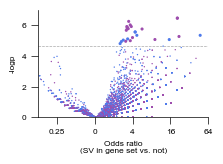

In [93]:
test_cat = "ANY.SINGLETON.ANY.ANY.ANY.protein_coding"

palette = {'neuroblastoma': mc.palette['neuroblastoma']["main"],
           'ewing': mc.palette['ewing']["main"]}

fig, ax = plt.subplots(1, figsize=(2.2, 1.4))

coding_results = combined_gse_results.query('sv_category == "coding"').copy()
coding_results["x_baseline"] = np.log2(coding_results["odds_ratio_cases_fisher"])
coding_results["y_baseline"] = -np.log10(coding_results["p_cases_fisher"])

data = coding_results.query(f'category == "{test_cat}"').copy()

nlp_bonf = -np.log10(p_bonf_cutoff)
data['size'] = np.where(data['y_baseline'] > nlp_bonf, 5, 1)
data['c'] = data['disease'].replace(palette)

# plot the significant ones first
sig = data.query(f'y_baseline > {nlp_bonf}')
points = ax.scatter(x = sig['x_baseline'], y = sig['y_baseline'], s = sig['size'], ec = None, c = sig['c'])

# labeled_sig = sig[sig['gs'].isin(labeled_gs)]
# points = ax.scatter(x = labeled_sig['x_baseline'], y = labeled_sig['y_baseline'], s = 10, ec = None, c = 'black')

nonsig = data.query(f'y_baseline < {nlp_bonf}').sample(frac = 1)
for chunk in np.array_split(nonsig, 200):
    zorder = np.random.uniform()
    points = ax.scatter(x = chunk['x_baseline'], y = chunk['y_baseline'], s = chunk['size'], ec = None, c = chunk['c'])

sns.despine(ax=ax)
ax.set_xlim([-3, 6])
ax.set_ylim([0, 7])
ax.axhline(
    y=nlp_bonf,
    linestyle="dashed",
    color="darkgrey",
    zorder=-1,
    linewidth = 0.5
)
ax.set_ylabel("-logp")
ax.set_xlabel("Odds ratio\n(SV in gene set vs. not)", fontsize = 6)

ax.set_xticks([-2, 0, 2, 4, 6])
ax.set_xticklabels([0.25, 0, 4, 16, 64])

# ax.legend(bbox_to_anchor = (1, 0.5))

fig.savefig('images/test-gene-sets-any.pdf')